In [1]:
import pickle
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from collections import defaultdict, Counter
from tqdm import tqdm

df = pd.read_pickle("lyrics_sentiment.pkl")

with open("../artist_data_pickle.pth", "rb") as f:
    artists = pickle.load(f)
    
WINDOW_SIZE = 15
BUCKETS = 100

In [2]:
def getSlidingWindowSentiment(sentiment, window_size=30):
    """
    Calculate the moving average of the sentiment over the window_size
    """
    return np.convolve(sentiment, np.ones(window_size)/window_size, mode='valid')

def normalizeProgression(slided_sentiment, buckets=100):
    """
    Convert the x-axis into buckets and average over the y-values in these buckets
    This is to normalize all song-lyrics to the same format
    Side effects: Long songs will be squeezed a lot.
    """
    bucket_size = int(len(slided_sentiment) / buckets)
    bucketed_sentiment = []
    for i in range(buckets):
        bucketed_sentiment.append(np.mean(slided_sentiment[i*bucket_size:(i+1)*bucket_size]))
    return bucketed_sentiment

#genre_sliding_sentiment = defaultdict(list)
genre_normalized_sentiment = defaultdict(list)
genre_normalized_emotion = defaultdict(list)
genre_mean_sentiment = defaultdict(list)
genre_mean_emotion = defaultdict(list)
genre_num_songs = Counter()
artist_emotion = Counter()
artist_sentiment = Counter()

total_sum_sentiment = 0
total_sum_emotion = 0
total_num_toks = 0
for artist_name, sentiment, has_sentiment in tqdm(zip(df["artist_name"],df["sentiment"], df["has_sentiment"]), total=len(df)):
    if len(sentiment) < BUCKETS + WINDOW_SIZE:
        continue
    sentiment = np.array(sentiment)
    mean_emotion = np.mean(np.abs(sentiment))
    mean_sentiment = np.mean(sentiment)
    total_sum_sentiment += np.sum(sentiment)
    total_sum_emotion += np.sum(np.abs(sentiment))
    total_num_toks += len(sentiment)
    artist_emotion[artist_name] = np.mean([np.abs(s) for s, h in zip(sentiment, has_sentiment) if h])
    artist_sentiment[artist_name] = np.mean([s for s, h in zip(sentiment, has_sentiment) if h])
    genres = artists[artist_name]['genres']
    slided_sentiment = getSlidingWindowSentiment(sentiment, WINDOW_SIZE)
    normalized_slided_sentiment = normalizeProgression(slided_sentiment, BUCKETS)
    slided_emotion = getSlidingWindowSentiment(np.abs(sentiment), WINDOW_SIZE)
    normalized_slided_emotion = normalizeProgression(slided_emotion, BUCKETS)
    for genre in genres:
        genre_mean_emotion[genre].append(mean_emotion)
        genre_mean_sentiment[genre].append(mean_sentiment)
        #genre_sliding_sentiment[genre].append(slided_sentiment)
        genre_normalized_sentiment[genre].append(normalized_slided_sentiment)
        genre_normalized_emotion[genre].append(normalized_slided_emotion)
        genre_num_songs[genre] += 1
mean_sentiment = total_sum_sentiment / total_num_toks
mean_emotion = total_sum_emotion / total_num_toks

100%|██████████| 44832/44832 [01:18<00:00, 571.07it/s]


In [3]:
genre_num_songs.most_common(10)

[('pop', 543),
 ('dance pop', 510),
 ('indie pop', 434),
 ('hip hop', 417),
 ('modern rock', 417),
 ('pop rap', 409),
 ('electropop', 405),
 ('rap', 403),
 ('rock', 391),
 ('indie folk', 364)]

In [4]:
from collections import Counter
genre_emotion = Counter()
genre_sentiment = Counter()
for genre in genre_mean_emotion.keys():
    if len(genre_mean_emotion[genre]) > 100:
        genre_emotion[genre] = np.stack(genre_mean_emotion[genre], axis=0).mean(0) - mean_emotion
        genre_sentiment[genre] = np.stack(genre_mean_sentiment[genre], axis=0).mean(0) - mean_sentiment

In [5]:
sorted(genre_emotion.items(), key=lambda x: x[1], reverse=False)[:10]

[('korean pop', -0.32488958944149376),
 ('k-pop girl group', -0.28138467905178943),
 ('k-pop', -0.2658100143180825),
 ('k-rap', -0.2460907814833192),
 ('french hip hop', -0.2020265225584793),
 ('funk carioca', -0.17617519055525432),
 ('nouvelle chanson francaise', -0.14453136217527351),
 ('brazilian hip hop', -0.13825980869504118),
 ('french rock', -0.13372550559971497),
 ('chanson', -0.13359407209519436)]

In [6]:
genre_emotion.most_common(10)

[('post-disco', 0.17657606125445147),
 ('disco', 0.15529241662034066),
 ('motown', 0.14777576132298909),
 ('quiet storm', 0.1415905899854727),
 ('latin pop', 0.1386557646043438),
 ('classic soul', 0.1384940151305496),
 ('latin rock', 0.13241252520074187),
 ('new jack swing', 0.13079186299343093),
 ('soul', 0.12795053905379172),
 ('funk', 0.1272671598165227)]

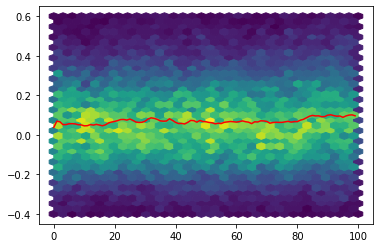

In [7]:
genre_values = np.array(genre_normalized_emotion["pop"]) - mean_emotion
Y = np.array(genre_values)
X = np.stack([np.arange(BUCKETS) for _ in range(len(genre_values))], axis=0)
plt.hexbin(X, Y, cmap=plt.cm.viridis, gridsize=33,extent=[0,BUCKETS,-0.4,0.6])
plt.plot(np.arange(BUCKETS), np.mean(genre_values, axis=0), color="red", linewidth=1.5)

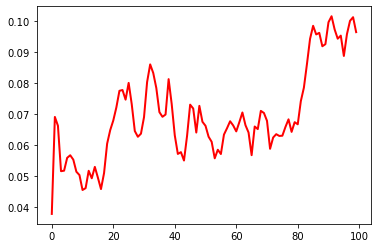

In [8]:
plt.plot(np.arange(BUCKETS), np.mean(genre_values, axis=0), color="red", linewidth=2)

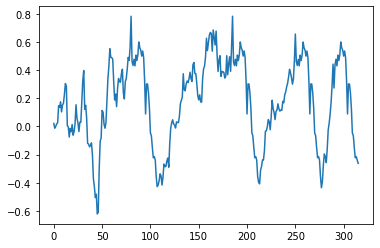

In [9]:
test_sentiment = np.array(df["sentiment"][44828]) - mean_sentiment
plt.plot(getSlidingWindowSentiment(test_sentiment,WINDOW_SIZE))

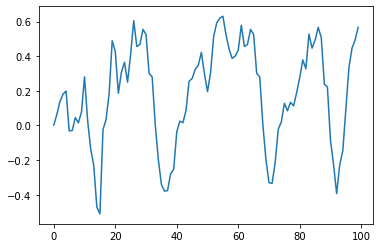

In [10]:
plt.plot(normalizeProgression(getSlidingWindowSentiment(test_sentiment,WINDOW_SIZE),BUCKETS))

In [11]:
genre_sentiment_availabilility = Counter()
genre_num_tokens = Counter()
for artist_name, has_sentiment in zip(df["artist_name"],df["has_sentiment"]):
    #sentiment = [s for s, h in zip(sentiment, has_sentiment) if h] # Only use the sentiment of tokens which have sentiment in library
    if len(has_sentiment) < BUCKETS + WINDOW_SIZE:
        continue
    genres = artists[artist_name]['genres']
    for genre in genres:
        genre_sentiment_availabilility[genre] += sum(has_sentiment)
        genre_num_tokens[genre] += len(has_sentiment)

for genre in genre_sentiment_availabilility.keys():
    genre_sentiment_availabilility[genre] /= genre_num_tokens[genre]

In [12]:
genre_sentiment_availabilility["k-pop"]

0.6771589933713692

In [20]:
all_dicts = {
    'genre_sentiment_availabilility': genre_sentiment_availabilility,
    'genre_emotion': genre_emotion,
    'genre_sentiment': genre_sentiment,
    'genre_normalized_sentiment': genre_normalized_sentiment,
    'genre_normalized_emotion': genre_normalized_emotion,
    'genre_mean_sentiment': genre_mean_sentiment,
    'genre_mean_emotion': genre_mean_emotion,
    'genre_num_songs': genre_num_songs,
    'genre_num_tokens': genre_num_tokens,
    'mean_sentiment': mean_sentiment,
    'mean_emotion': mean_emotion,
    'artist_emotion': artist_emotion,
    'artist_sentiment': artist_sentiment
}
with open("sentiment_analysis_data.pkl", "wb") as f:
    pickle.dump(all_dicts, f)

In [16]:
artist_emotion.most_common(10)

[('Lolita Flores', 1.9307692307692306),
 ('Rigoberta Bandini', 1.9140314136125647),
 ('Daisy Chainsaw', 1.7123618090452257),
 ('CAZZETTE', 1.7045787545787547),
 ('Suicide', 1.7032222222222222),
 ('KOPPS', 1.6911515151515149),
 ('Ogden Edsl', 1.6718918918918912),
 ('Lewis Blissett', 1.6232644628099175),
 ('Pieta Brown', 1.5998611111111112),
 ('Ely Guerra', 1.5848695652173912)]

In [17]:
artist_sentiment.most_common(10)

[('Lolita Flores', 1.8773076923076921),
 ('Rigoberta Bandini', 1.7682722513089),
 ('Daisy Chainsaw', 1.6920603015075373),
 ('Suicide', 1.651888888888889),
 ('Adelphi Music Factory', 1.5744615384615384),
 ('Pieta Brown', 1.55375),
 ('Ely Guerra', 1.5466086956521736),
 ('Sonia Y Selena', 1.5241558441558443),
 ('Saturday Night Band', 1.471186440677966),
 ('Pablo Ruiz', 1.459144385026738)]

In [19]:
sorted(artist_sentiment.items(), key=lambda x: x[1], reverse=False)[:10]

[('Mylo', -0.9719689119170984),
 ('KOPPS', -0.8926060606060604),
 ('CAZZETTE', -0.8636263736263737),
 ('MC Miguel', -0.6934939759036143),
 ('Ceremony', -0.5813138686131386),
 ('Ogden Edsl', -0.5554954954954955),
 ('Juliette & The Licks', -0.47774193548387106),
 ('Ty Segall', -0.45691275167785234),
 ('INFINITE', -0.4567441860465118),
 ('HOL!', -0.45580419580419584)]